In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from data_views import get_trip_and_history_tables

In [2]:
trip_features, leg_history = get_trip_and_history_tables()
trip_features.head()

,current_time,headway,monday,tuesday,wednesday,thursday,friday,saturday,sunday,to_target
half_trip_id,,,,,,,,,,
41926539.0,29209,988.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,319
41926541.0,34603,1430.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,443
41926543.0,40696,2281.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,361
41926545.0,47240,1268.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,487
41926547.0,53741,952.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,309


In [3]:
leg_history.head()

,to_maput,to_cntsq,to_mit,to_hynes,to_masta
half_trip_id,,,,,
41926539.0,181,176,173,161,130
41926541.0,289,220,288,275,352
41926543.0,419,279,230,277,168
41926545.0,303,232,262,322,232
41926547.0,364,157,245,258,269


# Loading into pytorch

In [4]:
target_col = "to_target"

y = trip_features.pop(target_col).to_numpy().astype('float32')
x_trip = trip_features.to_numpy().astype('float32')
x_hist = leg_history.to_numpy().astype('float32')

In [5]:
# Normalize values
x_trip = (x_trip - x_trip.mean()) / x_trip.std()
x_hist = (x_hist - x_hist.mean()) / x_hist.std()

In [7]:
alldata = data.TensorDataset(
    torch.from_numpy(x_trip),
    torch.from_numpy(x_hist),
    torch.from_numpy(y).reshape(-1, 1)
)

test_size = int(0.3*len(alldata))
train, test = data.random_split(alldata, [len(alldata)-test_size, test_size])

train_dl = data.DataLoader(train, batch_size=16, shuffle=True)
test_dl = data.DataLoader(test, batch_size=16)

In [8]:
train[0]

(tensor([ 3.4787, -0.2941, -0.3286, -0.3286, -0.3285, -0.3286, -0.3286, -0.3286,
         -0.3286]),
 tensor([1.3553, 0.1900, 0.4135, 3.3028, 0.4853]),
 tensor([399.]))

# Experiments

In [9]:
class HistoryEncoder(nn.Module):

    def __init__(self, num_stops, output_size):
        super(HistoryEncoder, self).__init__()
        self.num_stops = num_stops
        self.output_size = output_size
        
        self.fc1 = nn.Linear(self.num_stops, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, self.output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
        
class WithEncoding(nn.Module):
    def __init__(self, encoding_size=3):
        super(WithEncoding, self).__init__()
        
        self.encoding_size = encoding_size
        self.encoder = HistoryEncoder(5, self.encoding_size)
        
        self.trip_input_size = 9
        self.fc1 = nn.Linear(self.encoding_size + self.trip_input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, trip, hist):        
        encoded_hist = self.encoder(hist)
        x = torch.cat([trip, encoded_hist], axis=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
class NoEncoding(nn.Module):
    def __init__(self):
        super(NoEncoding, self).__init__()
        
        self.hist_input_size = 5
        self.trip_input_size = 9
        self.fc1 = nn.Linear(self.hist_input_size + self.trip_input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, trip, hist):        
        x = torch.cat([trip, hist], axis=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

print(WithEncoding())
print(NoEncoding())

WithEncoding(
  (encoder): HistoryEncoder(
    (fc1): Linear(in_features=5, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=3, bias=True)
  )
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
)
NoEncoding(
  (fc1): Linear(in_features=14, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
)


In [33]:
def run_loop(model, dl, loss_func, step=False, optimizer=None):
    total_loss = 0
    for trip, hist, y in dl:
        pred = model(trip, hist)
        loss = loss_func(pred, y)

        if step:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss

    return (total_loss / len(dl)).item()

def run_experiment(encoding = False, loss=nn.MSELoss(), lr=1e-2, epochs=20):
    model = WithEncoding() if encoding else NoEncoding()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        train_loss = run_loop(model, train_dl, loss, step=True, optimizer=opt)

        model.eval()
        with torch.no_grad():
            valid_loss = run_loop(model, test_dl, loss)

        print(f"Epoch {epoch}:\t training loss: {train_loss:,.1f}\t test loss: {valid_loss:,.1f}")
    return model

In [34]:
enc = run_experiment(encoding=True)

Epoch 0:	 training loss: 47,987.1	 test loss: 41,412.2
Epoch 1:	 training loss: 41,426.6	 test loss: 35,047.9
Epoch 2:	 training loss: 40,274.1	 test loss: 36,966.0
Epoch 3:	 training loss: 40,109.3	 test loss: 37,720.4
Epoch 4:	 training loss: 39,685.1	 test loss: 34,723.6
Epoch 5:	 training loss: 39,116.5	 test loss: 34,484.9
Epoch 6:	 training loss: 39,191.8	 test loss: 34,980.0
Epoch 7:	 training loss: 38,994.4	 test loss: 40,629.5
Epoch 8:	 training loss: 39,362.0	 test loss: 36,678.7
Epoch 9:	 training loss: 39,219.5	 test loss: 35,240.1
Epoch 10:	 training loss: 39,755.9	 test loss: 36,376.6
Epoch 11:	 training loss: 38,995.6	 test loss: 35,219.7
Epoch 12:	 training loss: 38,986.9	 test loss: 35,681.9
Epoch 13:	 training loss: 38,885.2	 test loss: 35,290.4
Epoch 14:	 training loss: 38,894.1	 test loss: 35,789.7
Epoch 15:	 training loss: 39,126.4	 test loss: 35,601.8
Epoch 16:	 training loss: 39,543.8	 test loss: 35,484.9
Epoch 17:	 training loss: 39,271.5	 test loss: 35,632.8
Ep

In [ ]:
enc = run_experiment(encoding=True)

In [16]:
enc = run_experiment(encoding=True, lr=1e-3, epochs=100)

Epoch 0:	 training loss: 101.3	 test loss: 72.1
Epoch 1:	 training loss: 74.0	 test loss: 70.9
Epoch 2:	 training loss: 73.5	 test loss: 70.3
Epoch 3:	 training loss: 73.2	 test loss: 72.2
Epoch 4:	 training loss: 73.1	 test loss: 70.2
Epoch 5:	 training loss: 72.8	 test loss: 70.0
Epoch 6:	 training loss: 73.0	 test loss: 72.7
Epoch 7:	 training loss: 72.7	 test loss: 70.5
Epoch 8:	 training loss: 72.4	 test loss: 69.8
Epoch 9:	 training loss: 72.1	 test loss: 70.6
Epoch 10:	 training loss: 70.2	 test loss: 67.6
Epoch 11:	 training loss: 68.8	 test loss: 65.7
Epoch 12:	 training loss: 67.8	 test loss: 64.5
Epoch 13:	 training loss: 67.1	 test loss: 65.8
Epoch 14:	 training loss: 66.6	 test loss: 63.7
Epoch 15:	 training loss: 66.2	 test loss: 64.2
Epoch 16:	 training loss: 66.1	 test loss: 63.7
Epoch 17:	 training loss: 65.7	 test loss: 63.4
Epoch 18:	 training loss: 65.7	 test loss: 63.5
Epoch 19:	 training loss: 65.7	 test loss: 64.7
Epoch 20:	 training loss: 65.6	 test loss: 63.0
E

In [17]:
trip, hist, y = next(iter(test_dl))

In [18]:
hist

tensor([[ 3.6558e-01, -6.4011e-01,  4.7732e-01,  7.0256e-02,  8.6842e-01],
        [ 1.0041e+00, -9.5937e-01,  1.9796e-01, -3.4479e-01, -1.5786e-03],
        [ 9.4025e-01,  2.9374e-01,  5.8906e-01,  1.6825e+00, -4.1487e-02],
        [-5.6827e-01, -8.9376e-02, -4.3259e-01, -4.3259e-01, -3.8470e-01],
        [-3.9268e-01, -9.1148e-01, -1.1669e+00, -1.0392e+00,  8.6219e-02],
        [ 4.7732e-01, -1.0392e+00, -2.9690e-01, -2.0910e-01, -4.4057e-01],
        [ 8.6044e-01,  3.9750e-01,  3.7356e-01,  7.2475e-01,  2.1455e+00],
        [-6.2414e-01, -1.2148e+00, -1.0631e+00, -4.6451e-01, -4.7249e-01],
        [ 1.5805e-01, -2.1708e-01, -4.0066e-01, -1.2130e-01,  4.3741e-01],
        [ 1.3154e+00,  4.4539e-01,  7.8860e-01,  3.3746e+00,  1.3234e+00],
        [-7.6781e-01, -1.4063e+00, -5.8424e-01, -1.6538e+00, -1.1270e+00],
        [-1.4525e-01,  2.3787e-01, -8.4763e-01,  6.3695e-01, -1.8516e-01],
        [-1.7717e-01, -4.1487e-02,  7.9658e-01, -5.6827e-01, -3.1286e-01],
        [ 1.4271e+00, -5.

In [ ]:
with torch.no_grad():
    pred = noenc(trip, hist)
    pred_with_bad_hist = noenc(trip, torch.rand((16,5)))
    plt.plot(pred, pred_with_bad_hist, ".k")

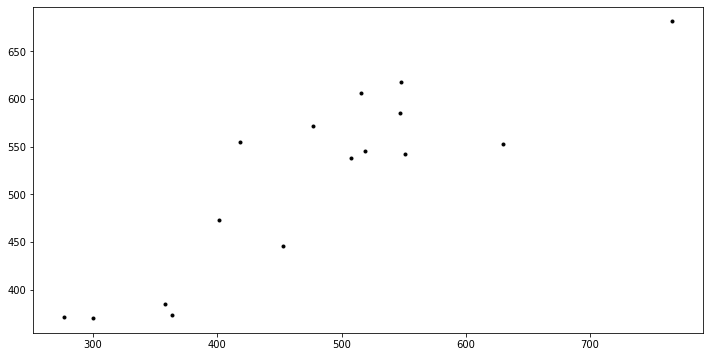

In [19]:
with torch.no_grad():
    pred = enc(trip, hist)
    pred_with_bad_hist = enc(trip, torch.rand((16,5)))
    plt.plot(pred, pred_with_bad_hist, ".k")

In [31]:
with torch.no_grad():
    print(run_loop(enc, test_dl, nn.MSELoss()))


36072.51953125


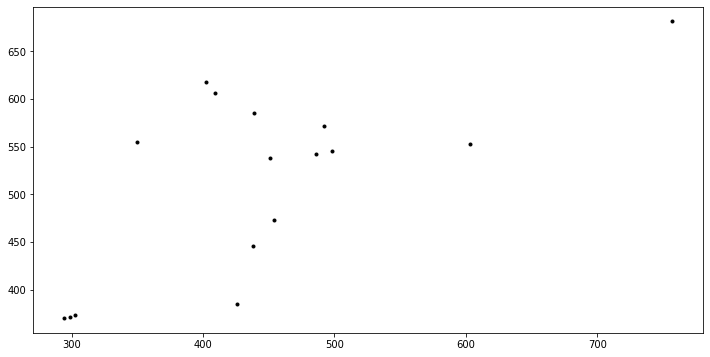

In [21]:
plt.plot(y, pred_with_bad_hist, ".k")

In [ ]:
plt.plot(durations[hist_lengths==1], preds[hist_lengths==1], ".k", alpha=.2)

In [ ]:
plt.plot(durations[hist_lengths==5], preds[hist_lengths==5], ".k", alpha=.2)

In [24]:
def get_predictions(model, dl):
    trips = []
    preds = []
    durations = []
    with torch.no_grad():
        for trip, hist, y in dl:
            pred = model(trip, hist)
            trips.append(trip)
            preds.append(pred)
            durations.append(y)
    trips = torch.cat(trips)
    preds = torch.cat(preds)
    durations = torch.cat(durations)
    return trips, preds, durations

trips, preds, durations = get_predictions(enc, test_dl)

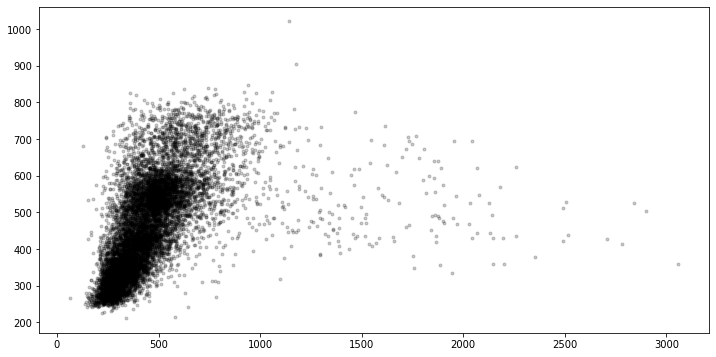

In [25]:
plt.plot(durations, preds, ".k", alpha=.2)

for enc with huburt(beta=100):
  r^2 = 0.2684277346564258
  mse = 36072.51953125


In [29]:
np.corrcoef(durations.flatten(), preds.flatten())[0,1]**2

0.2684277346564258

In [27]:
durations

tensor([[ 603.],
        [ 426.],
        [ 451.],
        ...,
        [ 150.],
        [1175.],
        [ 612.]])